<h1 style="text-align: center;">
    🌐 Generating Defect Density Wafer Maps
</h1>

This notebook demonstrates a version of `wafer_map_generation.ipynb`, where the patterns are also hand-crafted.

We will create defect density wafer maps containing scratches.

<link rel="stylesheet" href="https://cdn.jupyter.org/notebook/7.1.0/style/style.min.css">

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib.figure import Figure
from skimage import draw

from streamgen import visualizations
from streamgen.parameter.store import ParameterStore
from streamgen.samplers.tree import SamplingTree
from streamgen.transforms import operate_on_index

SEED = 42
rng = np.random.default_rng(SEED)

matplotlib.style.use("ggplot")
plt.ioff()  # disable interactive mode of matplotlib in order to show the plot just once

output_path = Path("./")
output_path.mkdir(parents=True, exist_ok=True)


def preprocess(x):
    x = np.array(x.to_list(), dtype=np.float32)

    # switch values for a better zero-center distribution
    x[x == 0] = np.nan
    x[x == 1] = 0
    x[x == 2] = 1

    return x


def plot(wafermap: np.ndarray, title: str | None = None, create_fig: bool = True, **kwargs) -> Figure | None:  # noqa: FBT001, FBT002
    if create_fig:
        fig = plt.figure()

    ax = sns.heatmap(wafermap.T, cmap="rocket_r", cbar=True, **kwargs)
    ax.grid(True)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

    return fig if create_fig else None

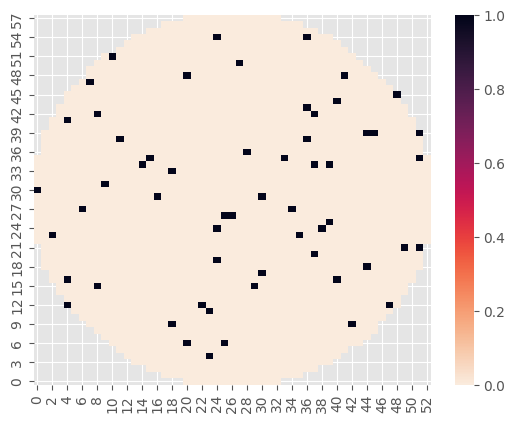

In [2]:
data_dir = Path("data")
df = pl.read_parquet("data/Center.parquet")
pattern_signal = preprocess(df["WaferMap"][0])
mask = np.isnan(pattern_signal)
background = np.zeros_like(pattern_signal)
noise = rng.normal(size=pattern_signal.shape)
background[noise > 2.0] = 1.0
background[mask] = np.nan
plot(background);

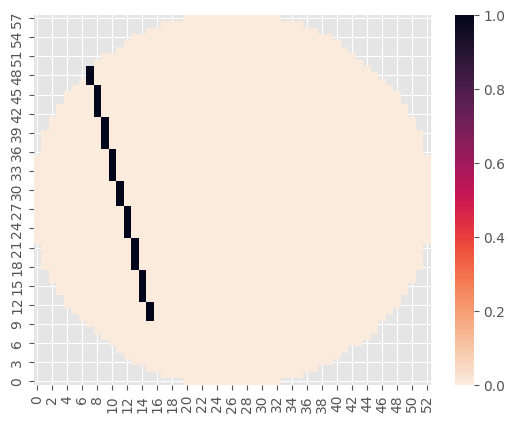

In [3]:
map = np.zeros_like(pattern_signal)

r0, c0 = rng.integers(map.shape)
r1, c1 = rng.integers(map.shape)
rr, cc = draw.line(r0, c0, r1, c1)
map[rr, cc] = 1.0

map[mask] = np.nan
plot(map);

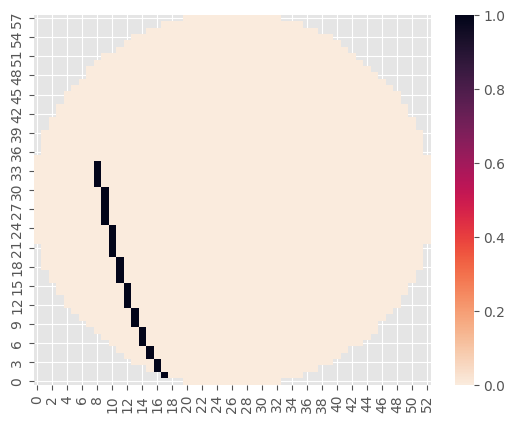

In [4]:
map = np.zeros_like(pattern_signal)

r0, c0 = rng.integers(map.shape)
r2, c2 = rng.integers(map.shape)
r1, c1 = rng.integers((min(r0, r2), min(c0, c2)), (max(r0, r2) + 1, max(c0, c2) + 1))

rr, cc = draw.bezier_curve(r0, c0, r1, c1, r2, c2, 1.0)
map[rr, cc] = 1.0

map[mask] = np.nan
plot(map);

In [5]:
# ➡️ functions


def zeros(_: None, shape: tuple[int]) -> np.ndarray:
    return np.zeros(shape)


def set_random_defects(x: np.ndarray, percentage_of_defects: float = 0.05) -> np.ndarray:
    noise = rng.uniform(0.0, 1.0, size=x.shape) < percentage_of_defects
    x[noise] = 1.0
    return x


def set_random_line(x: np.ndarray) -> np.ndarray:
    r0, c0 = rng.integers(x.shape)
    r1, c1 = rng.integers(x.shape)
    rr, cc = draw.line(r0, c0, r1, c1)
    x[rr, cc] = 1.0
    return x


def set_deterministic_scratch(x: np.ndarray, p0: tuple[int, int], p1: tuple[int, int]) -> np.ndarray:
    r0, c0 = p0
    r1, c1 = p1
    rr, cc = draw.line(r0, c0, r1, c1)
    x[rr, cc] = 1.0
    return x


def set_random_curve(x: np.ndarray, weight: float = 1.0) -> np.ndarray:
    r0, c0 = rng.integers(x.shape)
    r2, c2 = rng.integers(x.shape)
    r1, c1 = rng.integers((min(r0, r2), min(c0, c2)), (max(r0, r2) + 1, max(c0, c2) + 1))

    rr, cc = draw.bezier_curve(r0, c0, r1, c1, r2, c2, weight)
    x[rr, cc] = 1.0
    return x


def set_random_curve_in_region(x: np.ndarray, p0: tuple[int, int], p1: tuple[int, int], weight: float = 1.0) -> np.ndarray:
    r0, c0 = p0
    r2, c2 = p1
    r1, c1 = rng.integers((min(r0, r2), min(c0, c2)), (max(r0, r2) + 1, max(c0, c2) + 1))

    rr, cc = draw.bezier_curve(r0, c0, r1, c1, r2, c2, weight)
    x[rr, cc] = 1.0
    return x


@operate_on_index(0)
def apply_mask(x: np.ndarray, mask: np.ndarray) -> np.ndarray:
    x[mask] = np.nan
    return x

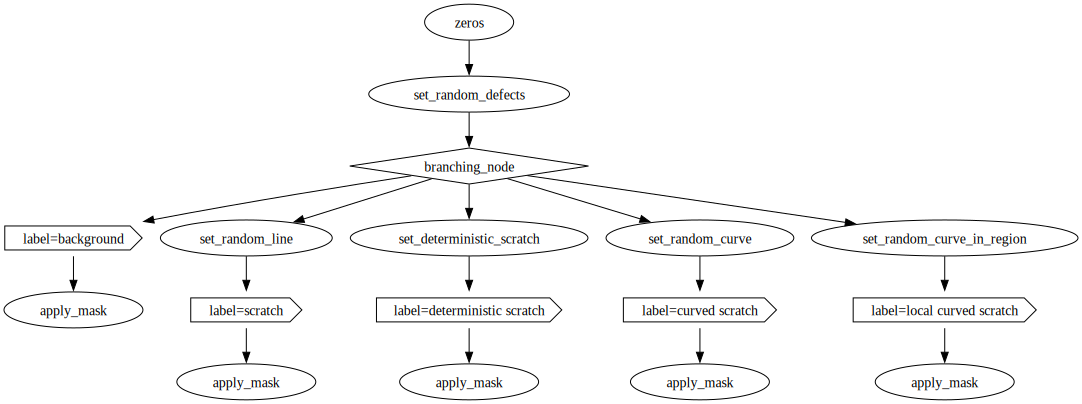

In [6]:
%matplotlib notebook

params = ParameterStore(
    {
        "zeros": {"shape": {"value": mask.shape}},
        "set_random_defects": {
            "percentage_of_defects": {"value": 0.05},
        },
        "set_deterministic_scratch": {
            "p0": {"value": (10, 20)},
            "p1": {"value": (20, 40)},
        },
        "set_random_curve": {
            "weight": {"value": 1.0},
        },
        "set_random_curve_in_region": {
            "weight": {"value": 2.0},
            "p0": {"value": np.array(mask.shape) // 3},
            "p1": {"value": np.array(mask.shape) // 3 * 2},
        },
        "apply_mask": {"mask": {"value": mask}},
    },
)

tree = SamplingTree(
    [
        zeros,
        set_random_defects,
        {
            "probs": [0.2, 0.4, 0.2, 0.1, 0.1],
            "background": "background",
            "line": [set_random_line, "scratch"],
            "deterministic scratch": [set_deterministic_scratch, "deterministic scratch"],
            "curve": [set_random_curve, "curved scratch"],
            "local curve": [set_random_curve_in_region, "local curved scratch"],
        },
        apply_mask,
    ],
    params,
)

tree.to_svg(output_path / "tree", plot)

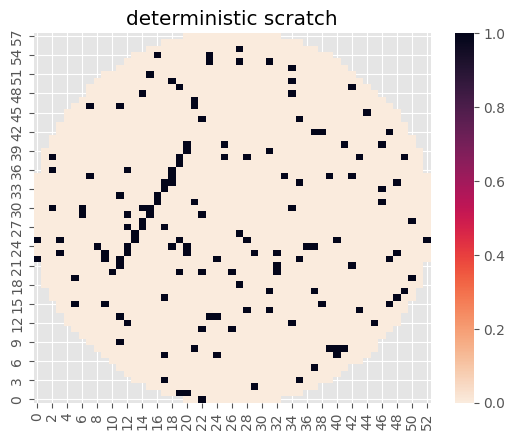

In [7]:
%matplotlib inline
sample, label = tree.sample()
plot(sample, title=label);

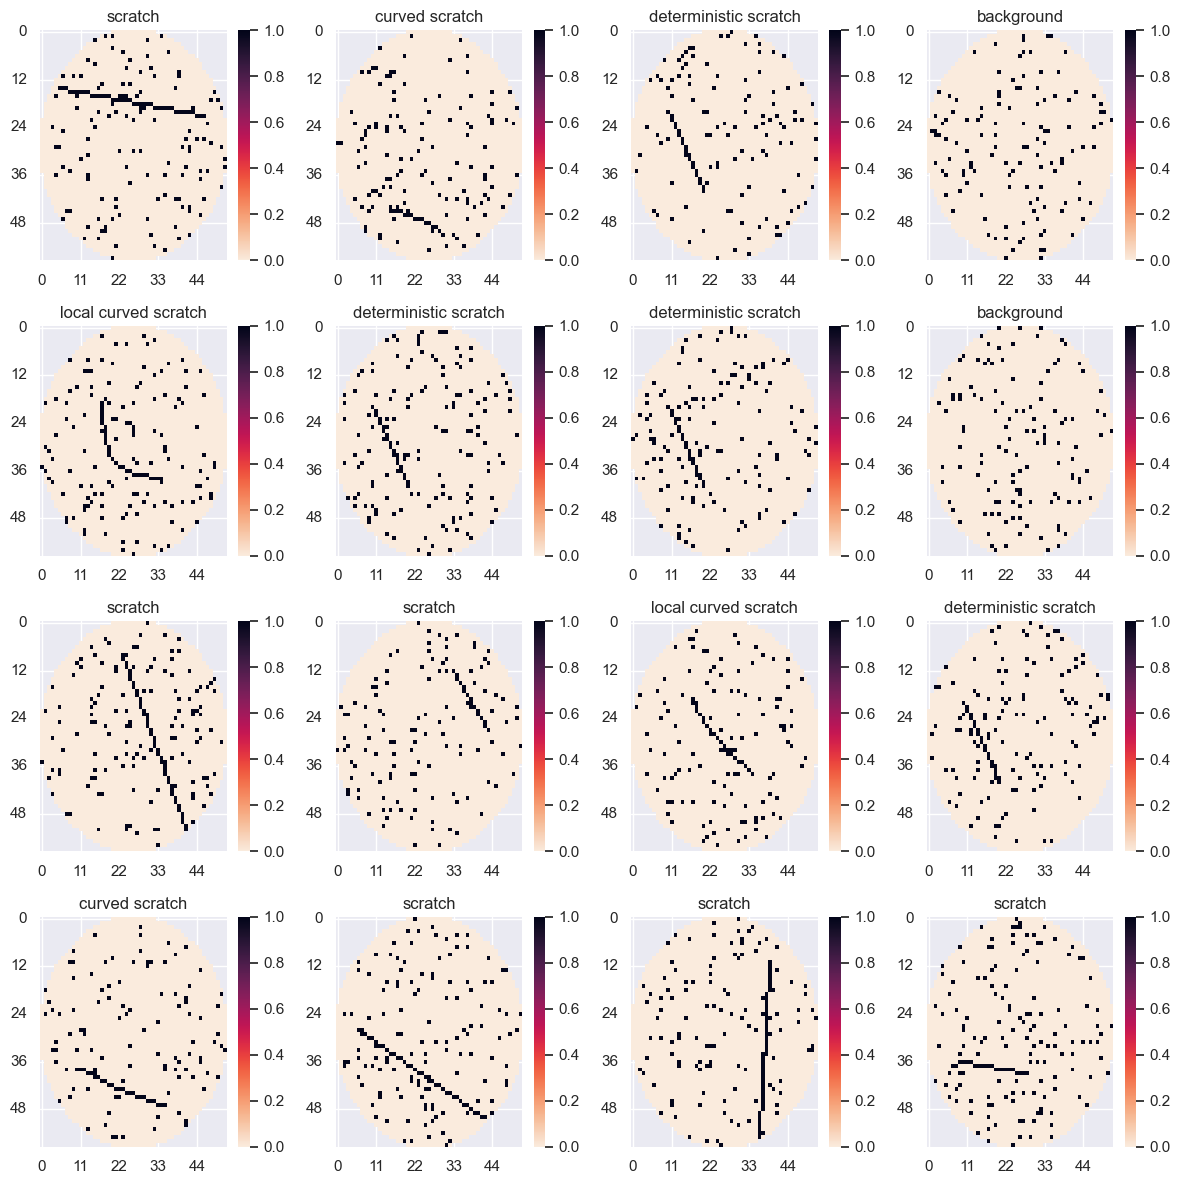

In [8]:
visualizations.plot_labeled_samples_grid(tree, lambda sample, ax: sns.heatmap(sample.T, cmap="rocket_r", cbar=True, ax=ax));

In [9]:
x, y = zip(*tree.collect(10000), strict=False)

Output()